In [1]:
import os
import sys
import csv
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import glob
import math
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import models
from sklearn.svm import OneClassSVM
from deep_svdd import BaseSVDD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D, Reshape
from tensorflow.keras import optimizers
from tensorflow.keras.applications.efficientnet import decode_predictions
from efficientnet.tfkeras import EfficientNetB2, preprocess_input
import MVTecAD_loaddata as mv
import pandas as pd
acc=[]

In [ ]:
%%time
for num in range(1):
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=3,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [ ]:
%%time
for num in range(1):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-6), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=3,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-6), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [ ]:
%%time
for num in range(1):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-6), gamma=10**(-3), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=3,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-6), gamma=10**(-3), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)



*** Fitting of the SVDD model is completed. ***

running time         = 2.5093 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.3736
number of samples    = 280
number of features   = 90112
number of SVs        = 132
ratio of SVs         = 47.1429 %
accuracy             = 81.4286 %




*** Prediction of the provided data is completed. ***

running time         = 0.3732 seconds
number of samples    = 28
number of alarm      = 13
accuracy             = 53.5714 %




*** Prediction of the provided data is completed. ***

running time         = 1.1892 seconds
number of samples    = 108
number of alarm      = 103
accuracy             = 95.3704 %




*** Prediction of the provided data is completed. ***

running time         = 1.3955 seconds
number of samples    = 136
number of alarm      = 116
accuracy             = 86.7647 %




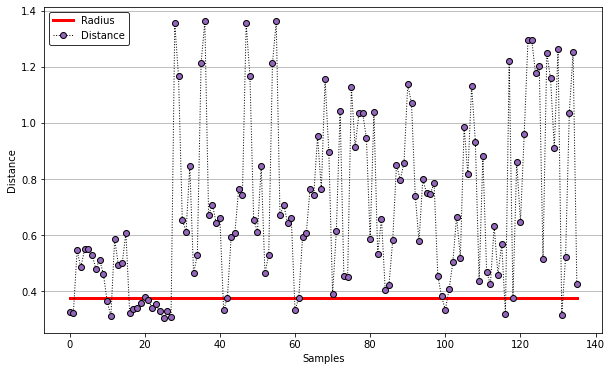

Epoch 1/3
9/9 [==============================] - 107s 10s/step - loss: 1.1754 - accuracy: 0.3885 - val_loss: 1.1763 - val_accuracy: 0.3887
Epoch 2/3
9/9 [==============================] - ETA: 0s - loss: 1.1755 - accuracy: 0.4013

KeyboardInterrupt: 

In [2]:
%%time
for num in range(1):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-7), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=3,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-7), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [ ]:
%%time
for num in range(1):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=3,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [ ]:
%%time
for num in range(1):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-6), gamma=10**(-5), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=3,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-6), gamma=10**(-5), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [ ]:
%%time
for num in range(1):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=3,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [ ]:
%%time
for num in range(1):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=3,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [ ]:
%%time
for num in range(2):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), degree=5, kernel='poly', coef0=1, display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=3,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), degree=5, kernel='poly', coef0=1, display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

C:\Users\Shuta Tsuchio\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 3.5924 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9859
number of samples    = 320
number of features   = 90112
number of SVs        = 243
ratio of SVs         = 75.9375 %
accuracy             = 33.7500 %




*** Prediction of the provided data is completed. ***

running time         = 0.6308 seconds
number of samples    = 41
number of alarm      = 26
accuracy             = 36.5854 %




*** Prediction of the provided data is completed. ***

running time         = 1.4292 seconds
number of samples    = 119
number of alarm      = 115
accuracy             = 96.6387 %




*** Prediction of the provided data is completed. ***

running time         = 1.6590 seconds
number of samples    = 160
number of alarm      = 141
accuracy             = 81.2500 %




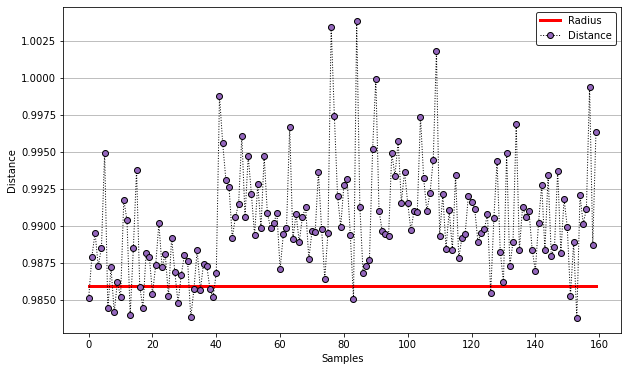

Epoch 1/2
16/16 [==============================] - 170s 9s/step - loss: 2.4707 - accuracy: 0.3339 - val_loss: 2.5413 - val_accuracy: 0.3059
Epoch 2/2
16/16 [==============================] - 147s 9s/step - loss: 4.4772 - accuracy: 0.3030 - val_loss: 3.5533 - val_accuracy: 0.3291


C:\Users\Shuta Tsuchio\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 3.1310 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9885
number of samples    = 320
number of features   = 90112
number of SVs        = 241
ratio of SVs         = 75.3125 %
accuracy             = 31.2500 %




*** Prediction of the provided data is completed. ***

running time         = 1.5065 seconds
number of samples    = 119
number of alarm      = 117
accuracy             = 98.3193 %




*** Prediction of the provided data is completed. ***

running time         = 0.5773 seconds
number of samples    = 41
number of alarm      = 27
accuracy             = 34.1463 %




*** Prediction of the provided data is completed. ***

running time         = 1.7415 seconds
number of samples    = 160
number of alarm      = 144
accuracy             = 81.8750 %




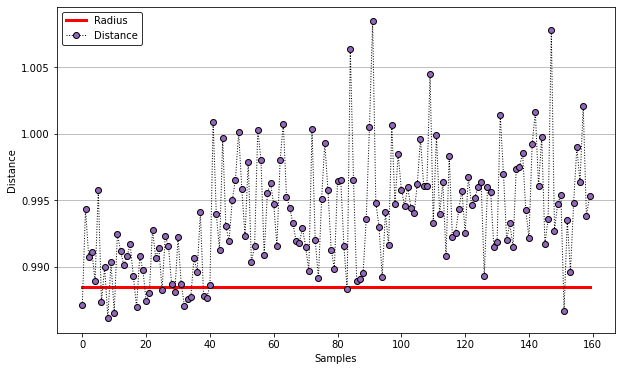

C:\Users\Shuta Tsuchio\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 3.3456 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9859
number of samples    = 320
number of features   = 90112
number of SVs        = 243
ratio of SVs         = 75.9375 %
accuracy             = 33.7500 %




*** Prediction of the provided data is completed. ***

running time         = 0.7789 seconds
number of samples    = 41
number of alarm      = 26
accuracy             = 36.5854 %




*** Prediction of the provided data is completed. ***

running time         = 1.8915 seconds
number of samples    = 119
number of alarm      = 115
accuracy             = 96.6387 %




*** Prediction of the provided data is completed. ***

running time         = 1.9189 seconds
number of samples    = 160
number of alarm      = 141
accuracy             = 81.2500 %




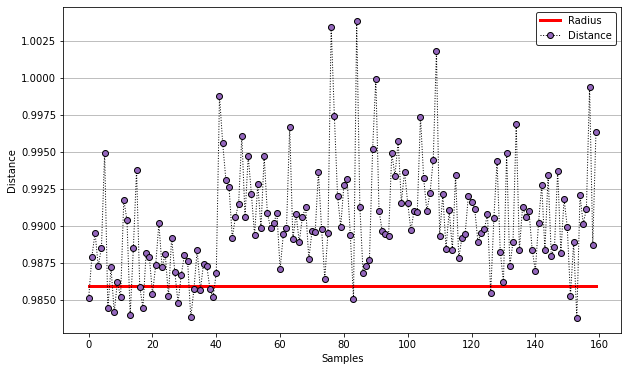

Epoch 1/2
16/16 [==============================] - 175s 9s/step - loss: 2.3870 - accuracy: 0.3453 - val_loss: 2.3959 - val_accuracy: 0.4250
Epoch 2/2
16/16 [==============================] - 143s 9s/step - loss: 2.8095 - accuracy: 0.4168 - val_loss: 2.9848 - val_accuracy: 0.3799


C:\Users\Shuta Tsuchio\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 3.1902 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9924
number of samples    = 320
number of features   = 90112
number of SVs        = 284
ratio of SVs         = 88.7500 %
accuracy             = 17.8125 %




*** Prediction of the provided data is completed. ***

running time         = 1.3354 seconds
number of samples    = 119
number of alarm      = 118
accuracy             = 99.1597 %




*** Prediction of the provided data is completed. ***

running time         = 0.5641 seconds
number of samples    = 41
number of alarm      = 34
accuracy             = 17.0732 %




*** Prediction of the provided data is completed. ***

running time         = 1.4908 seconds
number of samples    = 160
number of alarm      = 152
accuracy             = 78.1250 %




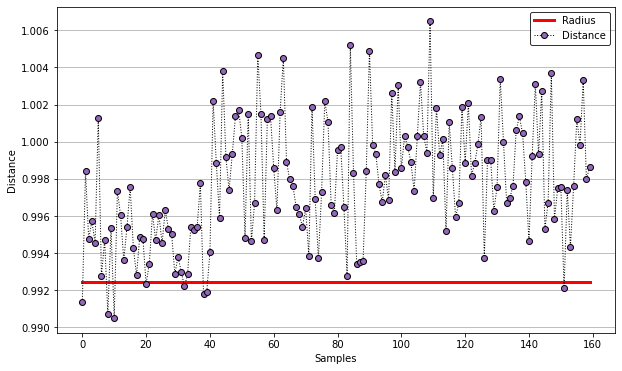

CPU times: total: 37min 32s
Wall time: 14min 52s


In [2]:
%%time
for num in range(2):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [ ]:
%%time
for num in range(1):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-3), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=3,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-3), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [ ]:
%%time
for num in range(1):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-3), gamma=10**(-4), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=3,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-3), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [ ]:
%%time
for num in range(1):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), gamma=10**(-5), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=3,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-2), gamma=10**(-5), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [ ]:
%%time
for num in range(1):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-5), gamma=10**(-5), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=3,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-5), gamma=10**(-5), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

C:\Users\Shuta Tsuchio\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.0364 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.0086
number of samples    = 240
number of features   = 90112
number of SVs        = 205
ratio of SVs         = 85.4167 %
accuracy             = 71.2500 %




*** Prediction of the provided data is completed. ***

running time         = 0.4081 seconds
number of samples    = 32
number of alarm      = 10
accuracy             = 68.7500 %




*** Prediction of the provided data is completed. ***

running time         = 1.1725 seconds
number of samples    = 119
number of alarm      = 103
accuracy             = 86.5546 %




*** Prediction of the provided data is completed. ***

running time         = 1.4709 seconds
number of samples    = 151
number of alarm      = 113
accuracy             = 82.7815 %




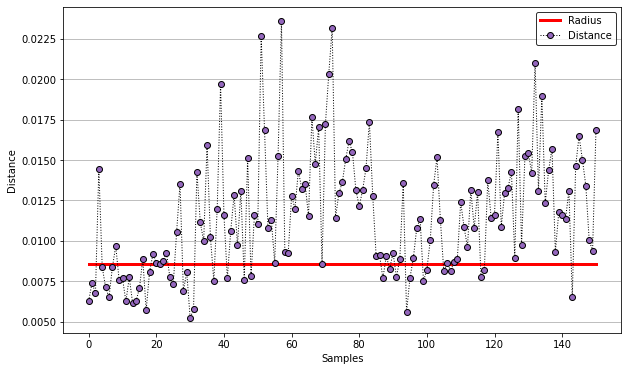

Epoch 1/2
13/13 [==============================] - 136s 9s/step - loss: 1.3255 - accuracy: 0.4251 - val_loss: 1.3262 - val_accuracy: 0.5631
Epoch 2/2
 6/13 [============>.................] - ETA: 50s - loss: 1.3692 - accuracy: 0.5526

In [ ]:
%%time
for num in range(2):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    X_train = np.array(X_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
#     model.fit(x_train, x_train,epochs=3,batch_size=8,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-7), gamma=10**(-8), kernel='rbf', display='on')
    
    svdd.fit(x_tr)
    svdd.predict(x_tg, y_tg)
    svdd.predict(x_te, y_te)
    svdd.predict(x_ts, y_ts)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)
    alphas = svdd.alpha
    Param = svdd.C
    m, n = x_tr.shape
    SV = []
    NSV = []
    for i in range(m):
      if alphas[i] > 0 and alphas[i] <= Param[0]:
        SV.append(list(X_train[i, :, :, :]))
      else:
        NSV.append(list(X_train[i, :, :, :]))
    sv = np.array(SV)
    nsv = np.array(NSV)
    model.fit(sv, sv,epochs=2,batch_size=16,shuffle=True,validation_data=(X_train, X_train))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

#     svdd = BaseSVDD(C=2**(-2), degree=2, kernel='poly', coef0=1, display='on')
    svdd = BaseSVDD(C=2**(-7), gamma=10**(-8), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [35]:
a = acc

In [41]:
a= a.reshape(65,3)
a.shape
df = pd.DataFrame(a)
print(df)
df.to_csv('output_pd.csv')

            0       1          2
0   98.412698  95.000  97.590361
1   98.412698  90.000  96.385542
2   98.412698  90.000  96.385542
3   98.412698  90.000  96.385542
4   98.412698  90.000  96.385542
..        ...     ...        ...
60  84.873950  65.625  80.794702
61  35.294118  84.375  45.695364
62  36.974790  75.000  45.033113
63  53.781513  50.000  52.980132
64  31.932773  87.500  43.708609

[65 rows x 3 columns]
